In [1]:
import sys
sys.path.append('../')

import os

import cqt
import cqt.env.mkt_env as env 
import cqt.env.mkt_env_spot as envspot
import cqt.ledger.ledger as ledger
import cqt.datagen as dg
import cqt.dbutility.dbutility as db
import cqt.strats.strategy as stg
import cqt.strats.strategy_long_short_average as stg_ls
import pandas as pd
import pickle

from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import copy
import cqt.strats.StrategyTensorFlow as stg_tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### db.get_table_list() method takes 1 argument db_id, and is defaulted to 'Amazon_RDS'
df_tbl_list=db.get_table_list()
print(df_tbl_list)

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


                                   table_name
0    coinapi-ohlcv-BINANCE_SPOT_BTC_USDT-1DAY
1    coinapi-ohlcv-BINANCE_SPOT_ETH_USDT-1DAY
2    coinapi-ohlcv-COINBASE_SPOT_LTC_USD-1DAY
3    coinapi-ohlcv-BINANCE_SPOT_ADA_USDT-1DAY
4         coinapi-ohlcv-DSX_SPOT_ETH_USD-1DAY
5      coinapi-ohlcv-KRAKEN_SPOT_XLM_USD-1DAY
6         coinapi-ohlcv-DSX_SPOT_LTC_USD-1DAY
7   coinapi-ohlcv-BINANCE_SPOT_IOTA_USDT-1DAY
8      coinapi-ohlcv-GEMINI_SPOT_BTC_USD-1DAY
9    coinapi-ohlcv-BINANCE_SPOT_EOS_USDT-1DAY
10        coinapi-ohlcv-DSX_SPOT_BCH_USD-1DAY
11     coinapi-ohlcv-KRAKEN_SPOT_EOS_USD-1DAY
12     coinapi-ohlcv-KRAKEN_SPOT_BCH_USD-1DAY
13     coinapi-ohlcv-KRAKEN_SPOT_XRP_USD-1DAY
14   coinapi-ohlcv-BINANCE_SPOT_LTC_USDT-1DAY
15   coinapi-ohlcv-COINBASE_SPOT_BTC_USD-1DAY
16   coinapi-ohlcv-BINANCE_SPOT_BCH_USDT-1DAY
17     coinapi-ohlcv-GEMINI_SPOT_ETH_USD-1DAY
18   coinapi-ohlcv-BINANCE_SPOT_XRP_USDT-1DAY
19     coinapi-ohlcv-KRAKEN_SPOT_ETH_USD-1DAY
20   coinapi-ohlcv-COINBASE_SPOT_B

In [16]:
TODAY = datetime.now()

tbl_name='coinapi-ohlcv-COINBASE_SPOT_BTC_USD-1DAY'
df_btc=db.get_from_db(tbl_name,from_date='2015-01-01',to_date='2017-01-01')
#df_eth = db.get_from_db("coinapi-ohlcv-COINBASE_SPOT_ETH_USD-1DAY",from_date='2016-01-01',to_date=TODAY.strftime('%Y-%M-%d'))



In [17]:
df_btc.data

,price_close,price_open,price_high,price_low,time_close,time_open,trades_count,volume_traded,key,last_updated
0,120.00,173.93,197.97,110.20,2015-01-14T19:40:43.0000000Z,2015-01-14T16:07:05.0000000Z,120,1.330000,2015-01-14,2018-07-02 11:51:28.312307
1,204.22,191.99,224.00,150.00,2015-01-15T23:58:02.0000000Z,2015-01-15T01:35:08.0000000Z,173,2.977321,2015-01-15,2018-07-02 11:51:28.312307
2,199.46,210.98,225.50,189.00,2015-01-16T23:04:23.0000000Z,2015-01-16T00:00:30.0000000Z,466,4.690000,2015-01-16,2018-07-02 11:51:28.312307
3,184.00,210.00,210.00,184.00,2015-01-17T18:32:11.0000000Z,2015-01-17T01:58:43.0000000Z,10,0.112000,2015-01-17,2018-07-02 11:51:28.312307
4,225.51,210.00,225.51,210.00,2015-01-19T03:49:55.0000000Z,2015-01-19T00:36:03.0000000Z,5,0.410000,2015-01-19,2018-07-02 11:51:28.312307
5,218.00,215.00,218.00,208.00,2015-01-20T23:52:27.0000000Z,2015-01-20T18:13:09.0000000Z,4,0.040000,2015-01-20,2018-07-02 11:51:28.312307
6,225.51,219.00,225.51,219.00,2015-01-21T23:04:45.0000000Z,2015-01-21T00:40:37.0000000Z,16,0.137707,2015-01-21,2018-07-02 11:51:28.312307
7,226.32,245.50,257.73,216.59,2015-01-22T06:03:03.0000000Z,2015-01-22T01:09:18.0000000Z,239,4.360000,2015-01-22,2018-07-02 11:51:28.312307
8,235.00,230.00,235.00,215.00,2015-01-23T20:39:33.0000000Z,2015-01-23T17:46:17.0000000Z,10,0.180001,2015-01-23,2018-07-02 11:51:28.312307
9,240.00,215.00,250.58,215.00,2015-01-24T22:37:30.0000000Z,2015-01-24T00:37:12.0000000Z,21,1.740000,2015-01-24,2018-07-02 11:51:28.312307


In [19]:
config = {'asset_type': 'spot'}
model_btc_eth = env.MktEnv([])
comp_btc = envspot.MktEnvSpot('btc', df_btc.get_index_data(), config)
model_btc_eth.insert_section(comp_btc)



cash = 10000
assets = {'btc': 0}
ini_pfo = ledger.Ledger(assets, cash)


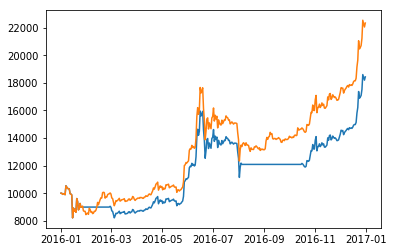

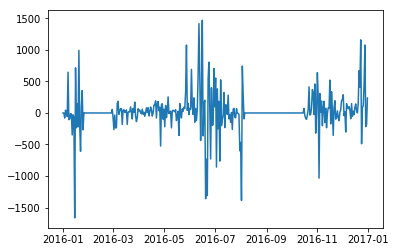

In [22]:
# Long/Short Average
ls_rule = {'method' : 'moving_average', 'window_size' : [15, 30], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_ls.StrategyInverseMA(model_btc_eth, ini_pfo, ls_rule)
start_date_str = '2016-01-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

longShortReport = report.copy()

In [47]:
longShortReport[-10:]

,date,total,pnl,cash,set_aside,btc_holding,btc_price
356,2016-12-22,16214.036147,407.614,0,0.0,18.9412,856.02
357,2016-12-23,17373.994529,1159.96,0,0.0,18.9412,917.26
358,2016-12-24,16886.069514,-487.925,0,0.0,18.9412,891.50
359,2016-12-25,16973.577805,87.5083,0,0.0,18.9412,896.12
360,2016-12-26,17086.656700,113.079,0,0.0,18.9412,902.09
361,2016-12-27,17524.387565,437.731,0,0.0,18.9412,925.20
362,2016-12-28,18603.467072,1079.08,0,0.0,18.9412,982.17
363,2016-12-29,18386.590464,-216.877,0,0.0,18.9412,970.72
364,2016-12-30,18198.883286,-187.707,0,0.0,18.9412,960.81
365,2016-12-31,18436.784613,237.901,0,0.0,18.9412,973.37


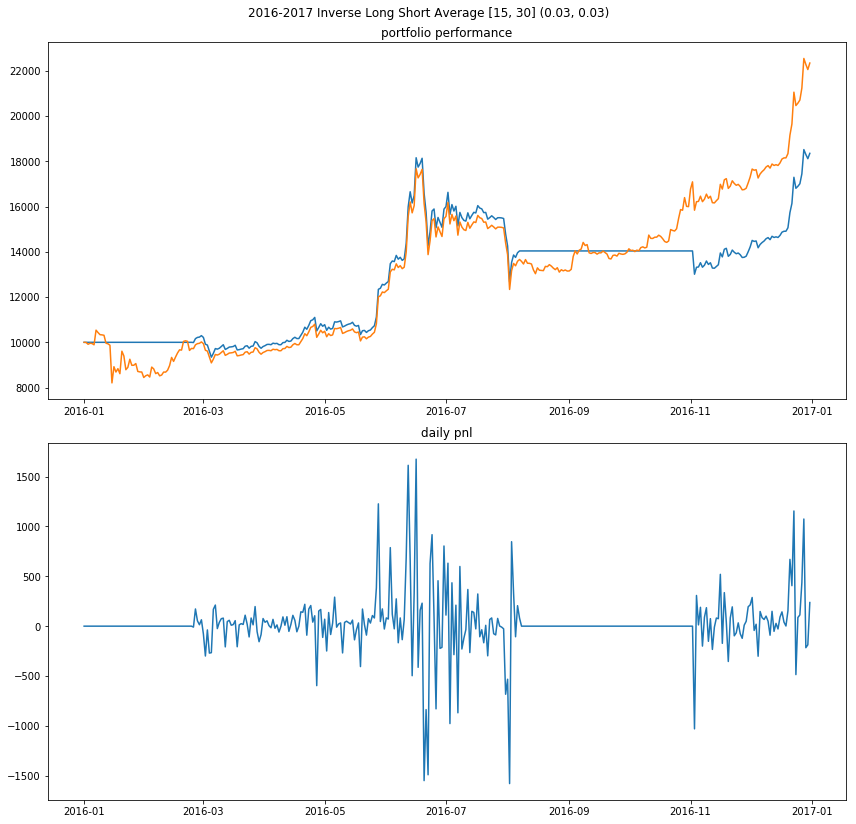

max daily gain: 1674.293532103602
max daily loss: -1578.053498136529


In [21]:
report = longShortReport
outDir='./'

strategyName = '2016-2017 Inverse Long Short Average [15, 30] (0.03, 0.03)'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())


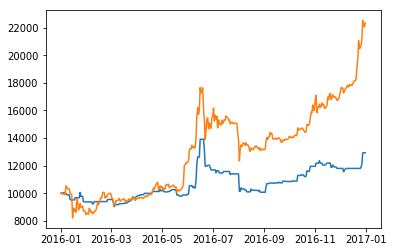

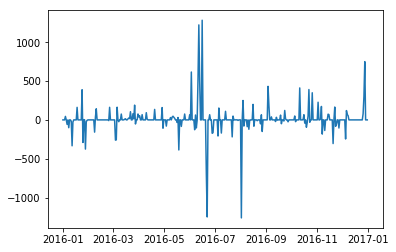

In [24]:
import cqt.strats.strategy_double_dip as stg_dd

# Double Dip Strategy
dd_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_dd.StrategyDoubleDip(model_btc_eth, ini_pfo, dd_rule)
start_date_str = '2016-01-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)


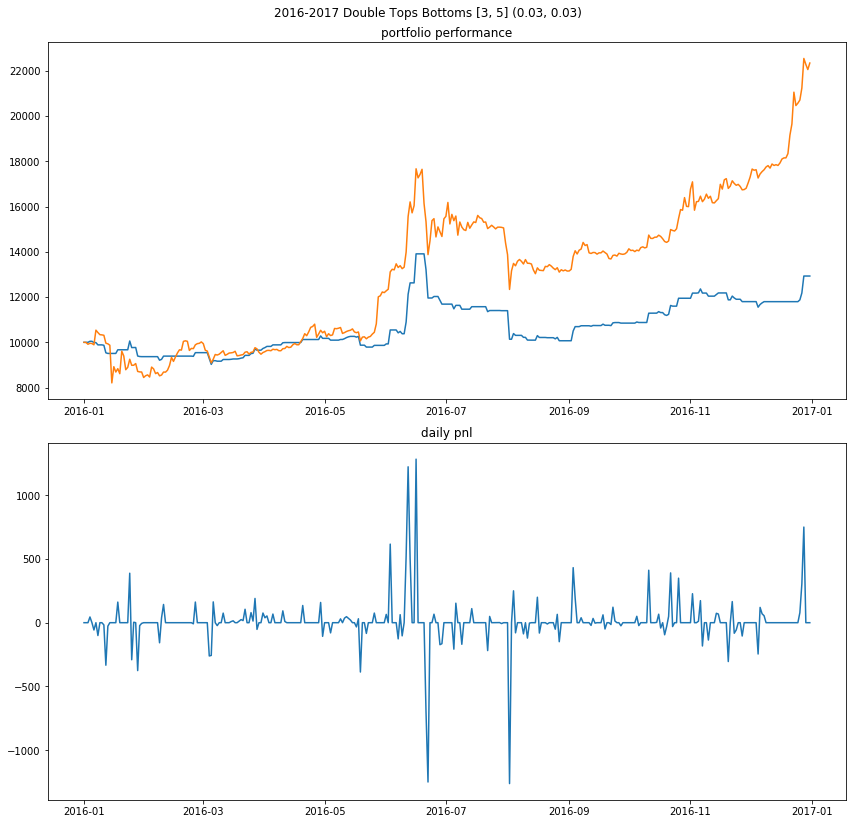

max daily gain: 1282.6014753524232
max daily loss: -1261.7345333869343


In [26]:
strategyName = '2016-2017 Double Tops Bottoms [3, 5] (0.03, 0.03)'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())

In [27]:
from talib.abstract import *
import copy
prices = copy.deepcopy(comp_btc.data)
prices.rename(columns={'price_open': 'open', 'price_high': 'high', 'price_low': 'low', 'price_close': 'close', 'volume_traded': 'volume'}, inplace=True)
close = prices['close'].values
sma15 = SMA(prices, timeperiod=15)
sma60 = SMA(prices, timeperiod=60)
rsi = RSI(prices, timeperiod=14)
atr = ATR(prices, timeperiod=14)


In [35]:
prices.index[-100:]

DatetimeIndex(['2016-09-24', '2016-09-25', '2016-09-26', '2016-09-27',
               '2016-09-28', '2016-09-29', '2016-09-30', '2016-10-01',
               '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05',
               '2016-10-06', '2016-10-07', '2016-10-08', '2016-10-09',
               '2016-10-10', '2016-10-11', '2016-10-12', '2016-10-13',
               '2016-10-14', '2016-10-15', '2016-10-16', '2016-10-17',
               '2016-10-18', '2016-10-19', '2016-10-20', '2016-10-21',
               '2016-10-22', '2016-10-23', '2016-10-24', '2016-10-25',
               '2016-10-26', '2016-10-27', '2016-10-28', '2016-10-29',
               '2016-10-30', '2016-10-31', '2016-11-01', '2016-11-02',
               '2016-11-03', '2016-11-04', '2016-11-05', '2016-11-06',
               '2016-11-07', '2016-11-08', '2016-11-09', '2016-11-10',
               '2016-11-11', '2016-11-12', '2016-11-13', '2016-11-14',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
      

In [28]:
import numpy
import talib

close = prices['close'].values

from talib import MA_Type

upper, middle, lower = talib.BBANDS(close, matype=MA_Type.T3)


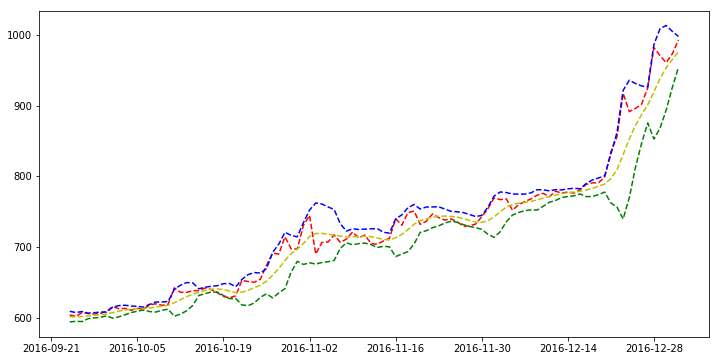

In [39]:
fig_width = 12
fig_height = 6
fig, ax0 = plt.subplots(1,1, figsize=(fig_width,fig_height))
ax0.plot(prices.index[-100:],close[-100:],  'r--',prices.index[-100:],upper[-100:],'b--',prices.index[-100:],middle[-100:], 'y--', prices.index[-100:],lower[-100:], 'g--')
plt.show()

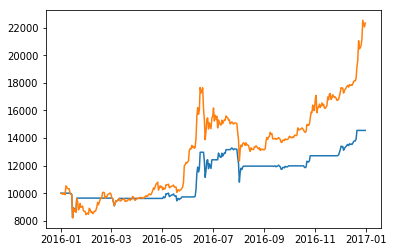

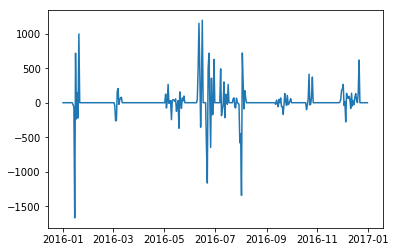

In [40]:
import cqt.strats.StrategyBBANDS as stg_bb

# B BANDS Strategy
dd_rule = {'method' : 'moving_average', 'window_size' : [3, 5], 'tolerance_up' : 0.03, 'tolerance_down' : 0.03}
strats = stg_bb.StrategyBBANDS(model_btc_eth, ini_pfo, dd_rule)
start_date_str = '2016-01-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

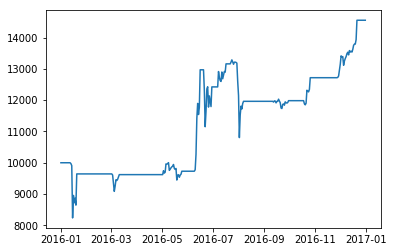

In [41]:
plt.plot(report['date'],report['total'])

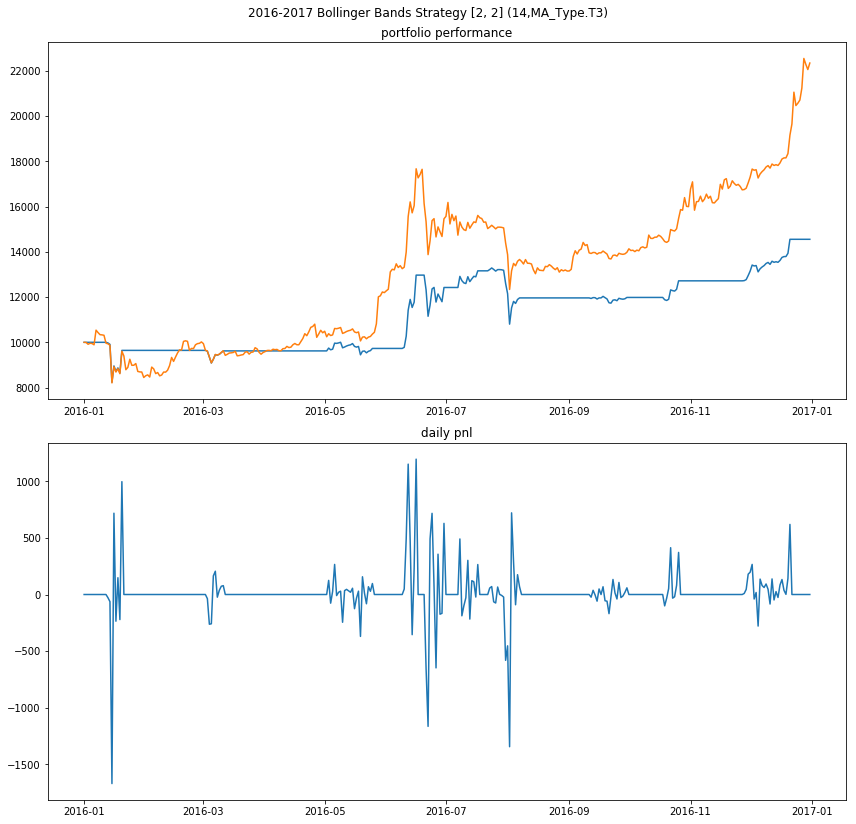

max daily gain: 1195.9465784011682
max daily loss: -1670.4684223865825


In [42]:
strategyName = '2016-2017 Bollinger Bands Strategy [2, 2] (14,MA_Type.T3)'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())

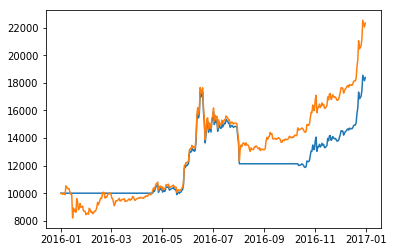

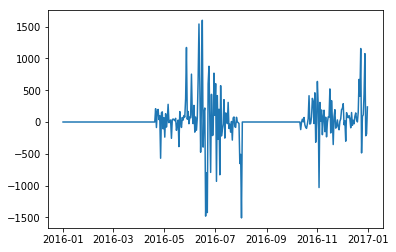

In [43]:
import cqt.strats.StrategyRSI as stg_rsi

# RSI Strategy
rsi_rule = {'method' : 'RSI'}
strats = stg_rsi.StrategyRSI(model_btc_eth, ini_pfo, rsi_rule)
start_date_str = '2016-01-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

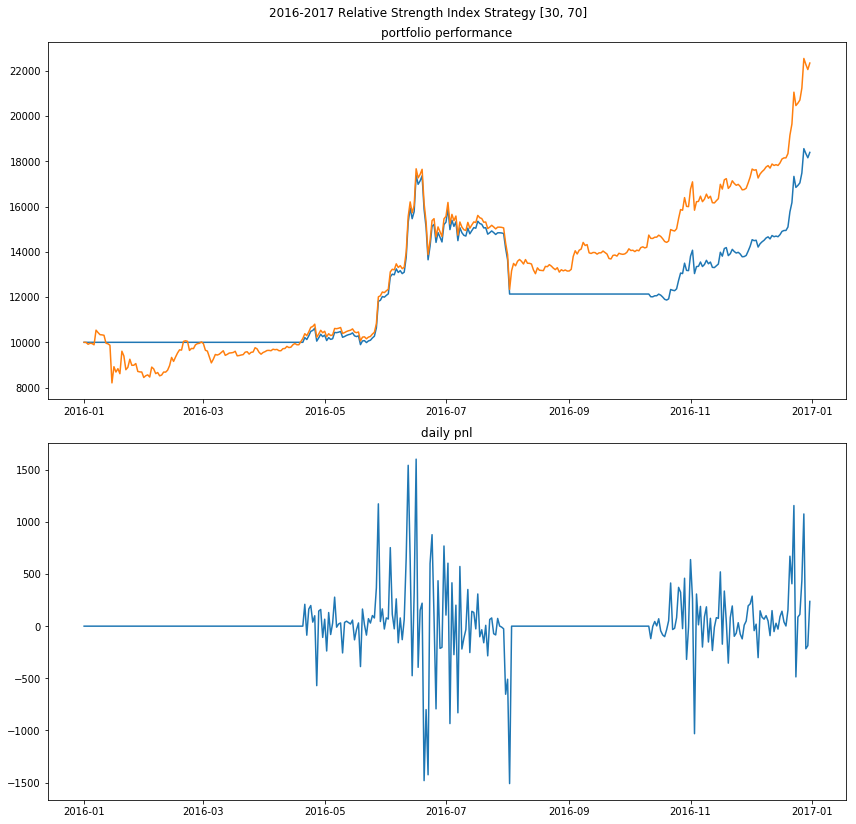

max daily gain: 1602.402022756005
max daily loss: -1510.2943832400215


In [44]:
strategyName = '2016-2017 Relative Strength Index Strategy [30, 70]'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())

In [46]:
report[-10:]

,date,total,pnl,cash,set_aside,btc_holding,btc_price
356,2016-12-22,16175.489509,406.645,0,0.0,18.8962,856.02
357,2016-12-23,17332.690249,1157.2,0,0.0,18.8962,917.26
358,2016-12-24,16845.925208,-486.765,0,0.0,18.8962,891.50
359,2016-12-25,16933.225460,87.3003,0,0.0,18.8962,896.12
360,2016-12-26,17046.035526,112.81,0,0.0,18.8962,902.09
361,2016-12-27,17482.725746,436.69,0,0.0,18.8962,925.20
362,2016-12-28,18559.239890,1076.51,0,0.0,18.8962,982.17
363,2016-12-29,18342.878876,-216.361,0,0.0,18.8962,970.72
364,2016-12-30,18155.617947,-187.261,0,0.0,18.8962,960.81
365,2016-12-31,18392.953696,237.336,0,0.0,18.8962,973.37


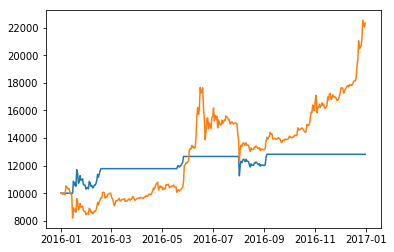

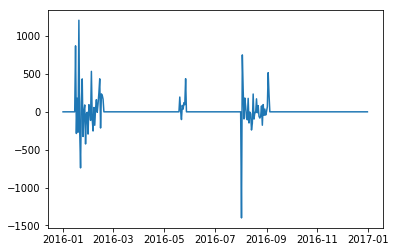

In [48]:
import cqt.strats.StrategyATR as stg_atr

# ATR Strategy
atr_rule = {'method' : 'ATR','bandwidth':[-2,2]}
strats = stg_atr.StrategyATR(model_btc_eth, ini_pfo, atr_rule)
start_date_str = '2016-01-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

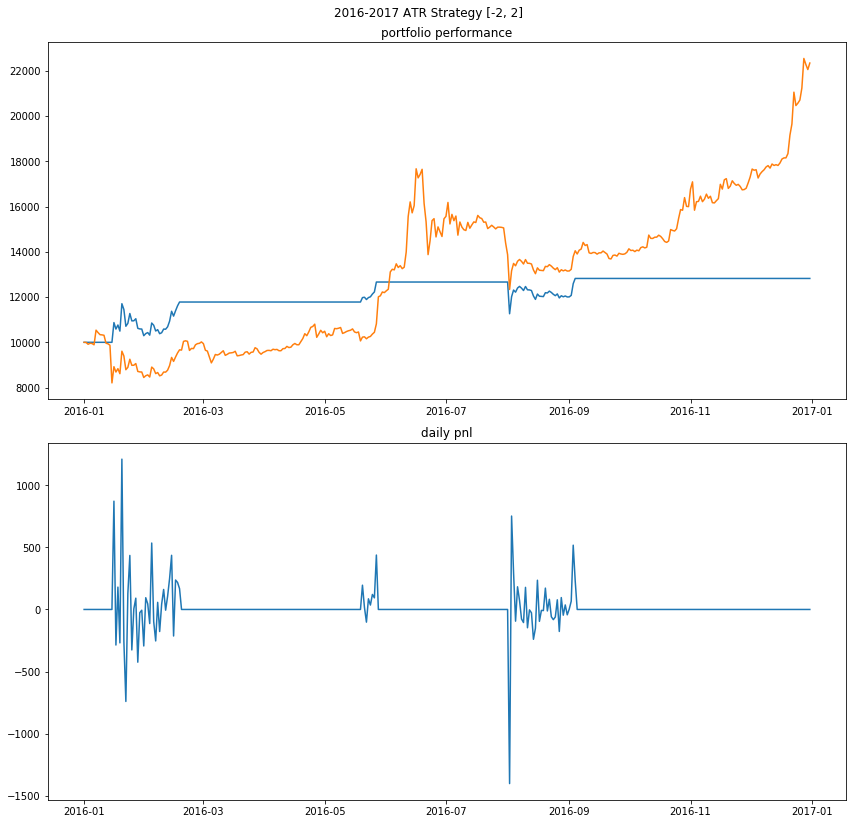

max daily gain: 1210.248091069283
max daily loss: -1401.870329362575


In [49]:
strategyName = '2016-2017 ATR Strategy [-2, 2]'
report.to_csv(os.path.join(outDir, strategyName+'.csv'), index=False)
fig_width = 12
fig_height = 12
fig, ax0 = plt.subplots(2,1, figsize=(fig_width,fig_height))
ax0[0].plot(report['date'], report['total'])
ax0[0].plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
ax0[0].set_title('portfolio performance')
ax0[1].plot(report['date'], report['pnl'])
ax0[1].set_title('daily pnl')
fig.suptitle(strategyName)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig(os.path.join(outDir, strategyName+'.pdf'))
plt.show()

print('max daily gain:', report['pnl'].max())
print('max daily loss:', report['pnl'].min())